<a href="https://colab.research.google.com/github/kozleo/stable_dynamics/blob/master/time_warp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ahwillia/affinewarp.git


fatal: destination path 'affinewarp' already exists and is not an empty directory.


In [ ]:
%cd /content/affinewarp

! pip install .
! pip install -r requirements.txt

/content/affinewarp
Processing /content/affinewarp
  Created wheel for affinewarp: filename=affinewarp-0.1.0-cp36-none-any.whl size=34982 sha256=8787aa7c44775bf1d3701c9598c1eab8f9276364e9644d68681626c87a4f2068
  Stored in directory: /tmp/pip-ephem-wheel-cache-52ghw5gq/wheels/32/41/b2/c2df19653331191a999e6e31010dc86845b843b7a603fa56ad
Successfully built affinewarp
  Found existing installation: affinewarp 0.1.0
    Uninstalling affinewarp-0.1.0:
      Successfully uninstalled affinewarp-0.1.0


In [ ]:
import scipy.io as sio
import numpy as np
mat_contents = sio.loadmat('/content/drive/My Drive/out2warp (2).mat')



In [ ]:
conds1 = np.where(mat_contents['conds'][0] - 1 == 1)[0]
#unit_ids = mat_contents['unit_ids'][0] - 1

unit_ids_good = np.concatenate([np.where(unit_ids == i)[0] for i in range(20)])



trials2samp = np.intersect1d(conds1,unit_ids_good) #np.random.choice(range(mat_contents['spiketimes'][0].shape[0]),np.int(frac_spikes_2_samp*mat_contents['spiketimes'][0].shape[0]))


unique_trials = np.unique(mat_contents['trials'][0][trials2samp])
new_inds = mat_contents['trials'][0][trials2samp]

for i in range(len(unique_trials)):
  inds2switch = np.where(new_inds == unique_trials[i])[0]
  new_inds[inds2switch] = i*np.ones(inds2switch.shape[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Trial duration and bin size parameters.
TMIN = -1000  # ms
TMAX = 3200   # ms
BINSIZE = 10  # ms
NBINS = int((TMAX - TMIN) / BINSIZE)

# LFP parameters.
LOW_CUTOFF = 10  # Hz
HIGH_CUTOFF = 30  # Hz

# Hyperparameters for shift-only warping model.
SHIFT_SMOOTHNESS_REG = 0.5
SHIFT_WARP_REG = 1e-2
MAXLAG = 0.15

# Hyperparameters for linear warping model.
LINEAR_SMOOTHNESS_REG = 1.0
LINEAR_WARP_REG = 0.065


from affinewarp import SpikeData

# Spike times.
'''
S = dict(np.load("/content/affinewarp/examples/primate_motor_cortex/umi_spike_data.npz"))

data = SpikeData(
    trials=S["trials"],
    spiketimes=S["spiketimes"],
    neurons=S["unit_ids"],
    tmin=TMIN,
    tmax=TMAX,
)''';




data = SpikeData(
    trials = new_inds,
    spiketimes=mat_contents['spiketimes'][0][trials2samp]*1000,
    neurons=mat_contents['unit_ids'][0][trials2samp] - 1,
    tmin=TMIN,
    tmax=TMAX,
)



# Bin and normalize (soft z-score) spike times.
binned = data.bin_spikes(NBINS)
binned = binned - binned.mean(axis=(0, 1), keepdims=True)
binned = binned / (1e-2 + binned.std(axis=(0, 1), keepdims=True))



#take good neurons 
#binned = binned[:,:,unit_ids_good]



# Crop spike times when visualizing rasters.
cropped_data = data.crop_spiketimes(TMIN, TMAX)



# Load LFP traces (n_trials x n_timebins). Crop traces to [TMIN, TMAX).
#L = dict(np.load("/content/affinewarp/examples/primate_motor_cortex/umi_lfp_data.npz"))

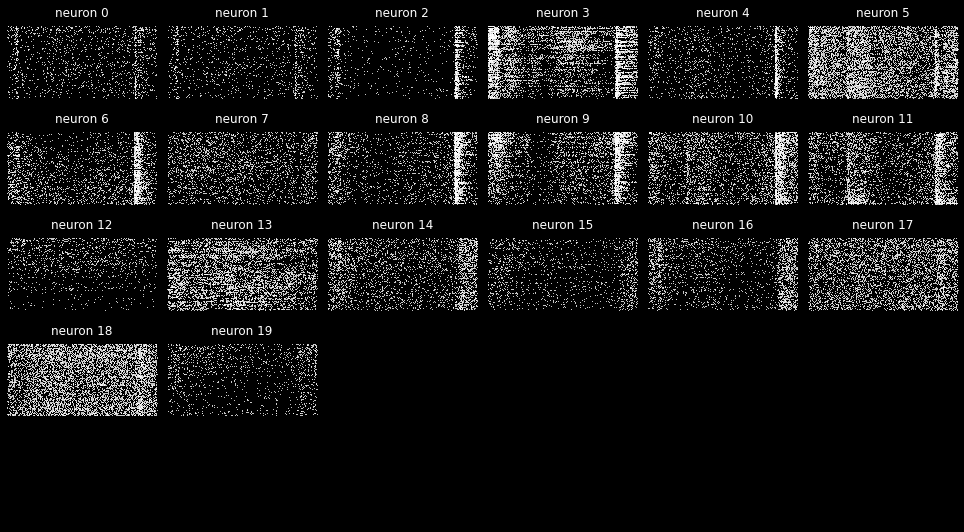

In [ ]:
from affinewarp.visualization import rasters
rasters(cropped_data);

In [ ]:
from affinewarp import ShiftWarping

# Specify model.
shift_model = ShiftWarping(
    smoothness_reg_scale=SHIFT_SMOOTHNESS_REG,
    warp_reg_scale=SHIFT_WARP_REG,
    maxlag=MAXLAG,
)

# Fit to binned spike times.
shift_model.fit(binned, iterations=50)

# Apply inverse warping functions to data.
shift_aligned_data = shift_model.transform(data).crop_spiketimes(TMIN, TMAX)

Loss: 0.86: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


In [ ]:
from affinewarp import PiecewiseWarping

# Specify model.
lin_model = PiecewiseWarping(
    n_knots=2,
    smoothness_reg_scale=LINEAR_SMOOTHNESS_REG,
    warp_reg_scale=LINEAR_WARP_REG,
    n_restarts = 2
)

# Fit to binned spike times.
lin_model.fit(binned, iterations=50)

# Apply inverse warping functions to data.
linear_aligned_data = lin_model.transform(data).crop_spiketimes(TMIN, TMAX)


Loss improvement: 0.83%: 100%|██████████| 50/50 [05:41<00:00,  6.84s/it]


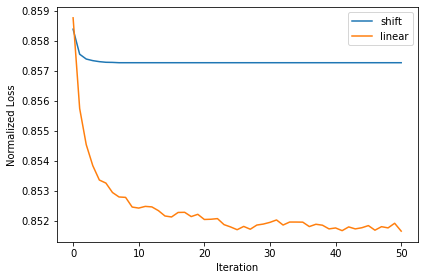

In [ ]:
plt.plot(shift_model.loss_hist, label="shift")
plt.plot(lin_model.loss_hist, label="linear")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()

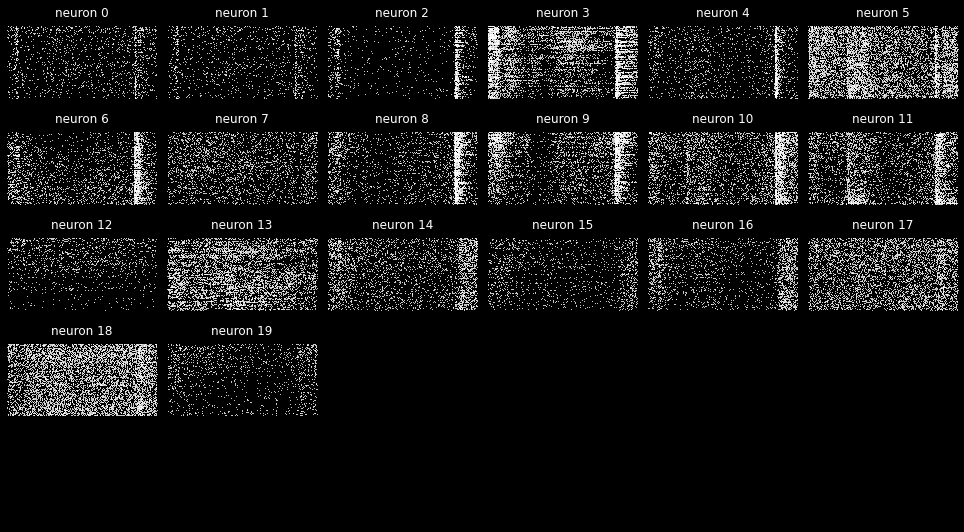

In [ ]:
from affinewarp.visualization import rasters
rasters(cropped_data);

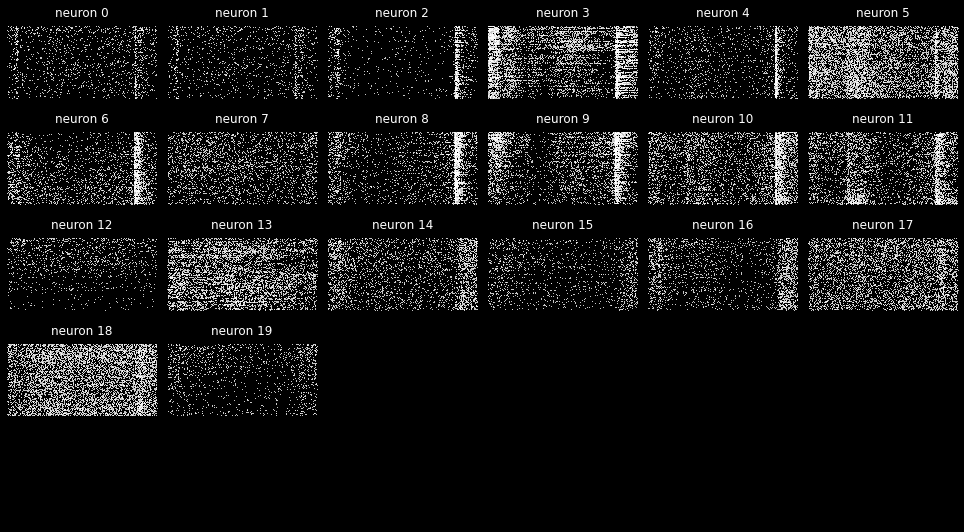

In [ ]:
rasters(shift_aligned_data);

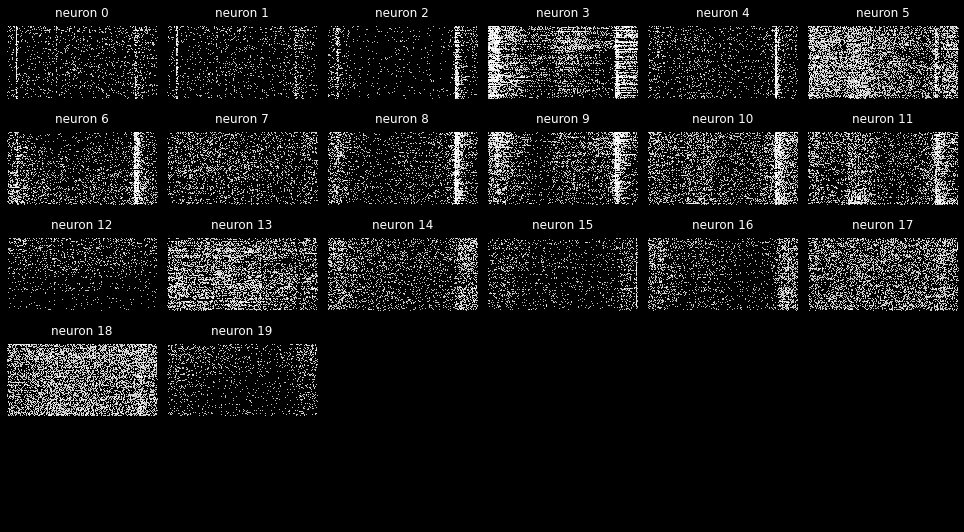

In [ ]:
rasters(linear_aligned_data);

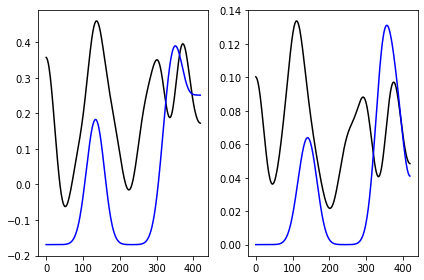

In [ ]:
binned_linear = linear_aligned_data.bin_spikes(NBINS);
from scipy.ndimage.filters import gaussian_filter1d as gf

neur = 11

trialone = 9
trialtwo = 25

plt.subplot(121)
tmp = gf(binned[trialone,:,neur],20,axis = 0)
tmp2 = gf(binned[trialtwo,:,neur],20, axis = 0)
plt.plot(tmp.T,'k');
plt.plot(tmp2.T,'b');
plt.tight_layout()


plt.subplot(122)
tmp = gf(binned_linear[trialone,:,neur],20,axis = 0)
tmp2 = gf(binned_linear[trialtwo,:,neur],20, axis = 0)
plt.plot(tmp.T,'k');
plt.plot(tmp2.T,'b');
plt.tight_layout()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

losses.py  metric.py  nets.py  utils.py  viz.py


Initialized empty Git repository in /content/contractionmetric/.git/


usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

error: pathspec 'commit”' did not match any file(s) known to git.
